In [29]:
import os,sys
import numpy as np
import scipy.stats as st
from scripts.BA_C import BA
import math
import random as rand
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy.stats as st
from matplotlib import rcParams
from matplotlib import gridspec
from sklearn.feature_selection import f_regression, mutual_info_regression

In [30]:
def sample_X(true_cdf):
    xi = rand.uniform(0,1.0)
    
    i = np.argwhere(true_cdf>xi)[0][0]
    
    return i

In [31]:
def next_jump(total_propensity):
    xi = rand.uniform(1e-6,1.0)
    dt = -math.log(xi)/total_propensity
    
    return dt

In [32]:
def next_jump_and_event_type(on,off,m_p,m_d):
    total = on + off + m_p + m_d
    
    xi = rand.uniform(0,1.0)
    
    if xi<m_p/total:
        event = 'm_p'
    elif xi>=m_p/total and xi<(m_p+m_d)/total:
        event = 'm_d'
    elif xi>=(m_p+m_d)/total and xi<(m_p+m_d+on)/total:
        event = 'on'
    else:
        event = 'off'
        
    xi = rand.uniform(1e-8,1.0)
        
    dt = -math.log(xi)/total
        
    return event, dt

In [33]:
data_directory = './Example_data/'
os.chdir(data_directory)

FileNotFoundError: [Errno 2] No such file or directory: './Example_data/'

In [34]:
# Optimal input distribution that achieves the ideal channel capacity for the integration time T

true_pX = np.array([1.97544481e-01,1.55334094e-01,8.72423287e-02,8.89069841e-02,5.95158979e-02,8.41338592e-02,2.72777107e-02,1.00156427e-01,2.62008568e-02,6.88904865e-09,1.73687353e-01])

X = np.linspace(0,1.0,true_pX.shape[0])
sX = np.linspace(0,1.0,true_pX.shape[0])

pr_array = np.zeros(shape=(X.shape[0],3))

true_cdf = np.zeros(shape=(true_pX.shape[0]))

for i in range(0,X.shape[0]):
    true_cdf[i] = np.sum(true_pX) - np.sum(true_pX[i+1:])
    
print(true_cdf)

[0.19754448 0.35287857 0.4401209  0.52902789 0.58854379 0.67267764
 0.69995536 0.80011178 0.82631264 0.82631265 1.        ]


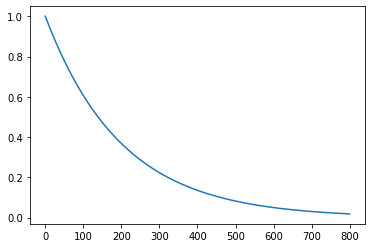

In [35]:
"""Parameters to compute the output of the deterministic integration channel. 
Leakiness, 0<l<1, which determines the rate of leaky transcription in the absence of the environmental input, X.
Frequency parameter, alpha>0, which determines the rate at which operator (O) switches between 0 and 1 states.

k_m = Transcription rate constant
k_dm = Transcript decay rate constant

T = Dimensionless integration time, the protein decay rate constant is computed as k_dg = k_dm/T.

Tf = Time period of fluctuation in the input.
kernel_window_size = Numerical width of the exponentially decaying kernel, e^{-k_dg t}.
"""

l = 0.01
alpha = 1.0

k_m = 0.5
k_dm = 0.5


T = 100
k_dg = k_dm/T

kernel_window_size = 4.0

# Change Tf relative to the translation response time 1/k_dg, and compute I(X;g_ideal)
Tf = 100.0/k_dg

kernel_window_time = kernel_window_size/k_dg

kernel_points = int(kernel_window_size*k_dm/k_dg)
kernel_times = np.linspace(0,kernel_window_time,kernel_points+1)
kernel = np.zeros(shape=(kernel_points+1,))

for j in range(0,kernel_times.shape[0]):
    kernel[j] = math.exp(-k_dg*kernel_times[j])
    
plt.plot(kernel_times,kernel)

g_min = st.gamma.ppf(0.01,k_low,0,1)
g_max = st.gamma.ppf(0.99,k_up,0,1)
print(g_min,g_max)

bin_size = 50

g_bins = list(10**np.linspace(math.log10(0.1),math.log10(g_max+1),bin_size))
g_bins.insert(0,-1)
g_bins = np.array(g_bins)
g_pdfs = np.zeros(shape=(X.shape[0],bin_size))
expressions = np.zeros(shape=(X.shape[0]+1,bin_size))

In [36]:
# Repeats
reps = 10

# Sampling interval
t_sample = 1.0/k_dm

n_samples = int(1000*Tf/t_sample)

joint_samples = np.zeros(shape=(n_samples,3))
times = np.zeros(shape=(n_samples,))

print('Total samples of X during the protocol: ',(n_samples*t_sample)/Tf,n_samples)

Total samples of X during the protocol:  100.0 1000000


In [12]:
ii = sample_X(true_cdf)
tX = X[ii]

current_time = 0.0
event_counter = 0
last_sample_event = 0

# Operator state 
O_on = 0
O_off = 1

# Transcription on or off    
k_on = alpha*((1-l)*tX + l)
k_off = alpha*(1 - tX)*(1 - l)

# Initial transcript count
m_g = int((k_m/k_dm)*k_on/(k_on + k_off))

m_g_samples = np.zeros(shape=(n_samples,))
m_g_samples[0] = m_g

g_int = 0.0

current_time = 0
next_sample_time = t_sample
samples = 1
next_switch_time = Tf
X_samples = [tX]

while samples<n_samples:
    # Transcription on or off    
    k_on = alpha*((1-l)*tX + l)
    k_off = alpha*(1 - tX)*(1 - l)

    # transcription propensities
    m_production = k_m*O_on
    m_degradation = k_dm*m_g

    event, dt = next_jump_and_event_type(k_on,k_off,m_production,m_degradation)

    current_time += dt
    event_counter += 1

    if current_time>next_sample_time:
        joint_samples[samples,0] = tX
        joint_samples[samples,1] = m_g
        joint_samples[samples,2] = O_on
        
        times[samples] = current_time

        next_sample_time += t_sample + (current_time - next_sample_time)

        samples += 1

        last_sample_event = event_counter
        
    if current_time>next_switch_time:
        ii = sample_X(true_cdf)
        tX = X[ii]
        
        X_samples.append(tX)

        next_switch_time += Tf + (current_time - next_sample_time)        

    if event=='m_p':
        m_g += 1
    elif event=='m_d':
        m_g += -1
    elif event=='off':
        O_on = 0
        O_off = 1
    elif event=='on':
        O_on = 1
        O_off = 0

g_samples = np.convolve(np.array(joint_samples[:,1]),np.array(kernel),'valid')

In [13]:
print(g_samples.shape)
print(len(X_samples))
g_times = times[(times.shape[0]-g_samples.shape[0]):]

joint_g = np.zeros(shape=(g_times.shape[0],2))
joint_g[:,1] = g_samples
joint_g[:,0] = joint_samples[(times.shape[0]-g_samples.shape[0]):,0]

(99600,)
140


In [14]:
total_g_samples = {}

for iX in list(X):
    total_g_samples[str(iX)] = []
    
for i in range(0,g_times.shape[0]):
    total_g_samples[str(joint_g[i,0])].append(joint_g[i,1])
    
gmax, gmin = max(joint_g[:,1]), min(joint_g[:,0])

bin_size = min(25,int(gmax - gmin))
g_bins = np.linspace(gmin,gmax,bin_size+1)
g_pdfs = np.zeros(shape=(X.shape[0],bin_size))

for i in range(0,X.shape[0]):
    if i!=9:
        hist, be = np.histogram(total_g_samples[str(X[i])],g_bins)
        g_pdfs[i,:] = hist#/np.sum(hist)
    
g_pdfs *= 1.0/np.sum(np.sum(g_pdfs))
print(np.sum(np.sum(g_pdfs)))

0.9999999999999999


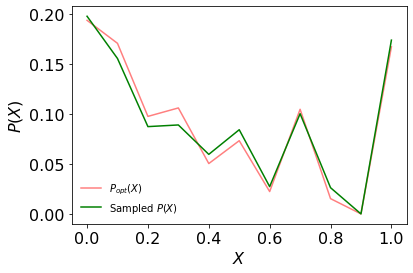

In [28]:
# Check in the sampled distribution of X matches the optimal input distribution
h, b = np.histogram(joint_samples[:,0],bins=X.shape[0])

h = h/np.sum(h)

plt.plot(X,h,alpha=0.5,color='r',label=r'$P_{opt}(X)$')
plt.plot(X,true_pX,color='g',label=r'Sampled $P(X)$')
plt.tick_params(labelsize=16)
plt.xlabel(r'$X$',size=16)
plt.ylabel(r'$P(X)$',size=16)
plt.legend(frameon=False)

In [17]:
pX = np.sum(g_pdfs,axis=1)
pg = np.sum(g_pdfs,axis=0)

mi = 0.0

for i in range(0,g_pdfs.shape[0]):
    for j in range(0,g_pdfs.shape[1]):
        if pX[i]>0.0 and pg[j]>0.0 and g_pdfs[i,j]>0.0:
            mi += g_pdfs[i,j]*math.log(g_pdfs[i,j]/(pX[i]*pg[j]))
            
mi *= 1.0/math.log(2.0)
print(mi)

1.5024207057105756


casename = 'expressions'+str(k_g).replace('.','_')+'-'+str(k_dg).replace('.','_')+'.csv'

expressions[1:,:] = g_pdfs

lg_bins = list(np.log10(g_bins))
g_head = np.array([0.5*(lg_bins[i]+lg_bins[i+1]) for i in range(0,len(lg_bins)-1)])

expressions[0,:] = 10**g_head

np.savetxt(casename,expressions,delimiter=',')

In [18]:
filename = 'Ifluc'+str(int(T))+'.csv'

try:
    ff = open(filename,'a')
except OSError:
    ff = open(filename,'w')
    print('Tf,rTf,T,I',file=ff)
    ff.close()
    
print(str(Tf)+','+str(Tf*k_dg)+','+str(k_dm/k_dg)+','+str(mi),file=open(filename,'a'))